In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/traffic_data/traffic_speed_sub-dataset.csv'

In [ ]:
df = pd.read_csv(file_path, names=["road_segment_id", "timestamp", "traffic_speed"], header=None)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264386688 entries, 0 to 264386687
Data columns (total 3 columns):
 #   Column           Dtype  
---  ------           -----  
 0   road_segment_id  int64  
 1   timestamp        int64  
 2   traffic_speed    float64
dtypes: float64(1), int64(2)
memory usage: 5.9 GB


In [ ]:
df.head()

,road_segment_id,timestamp,traffic_speed
0,1562548955,0,41.348069
1,1562548955,1,37.241356
2,1562548955,2,33.832750
3,1562548955,3,40.403444
4,1562548955,4,49.843057


In [ ]:
df.isnull().sum()

,0
road_segment_id,0
timestamp,0
traffic_speed,0


# Очистка данных от выбросов скоростей

In [ ]:
df_clean = df[(df['traffic_speed'] >= 0) & (df['traffic_speed'] <= 120)]

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264386688 entries, 0 to 264386687
Data columns (total 3 columns):
 #   Column           Dtype  
---  ------           -----  
 0   road_segment_id  int64  
 1   timestamp        int64  
 2   traffic_speed    float64
dtypes: float64(1), int64(2)
memory usage: 5.9 GB


# Распределение скоростей


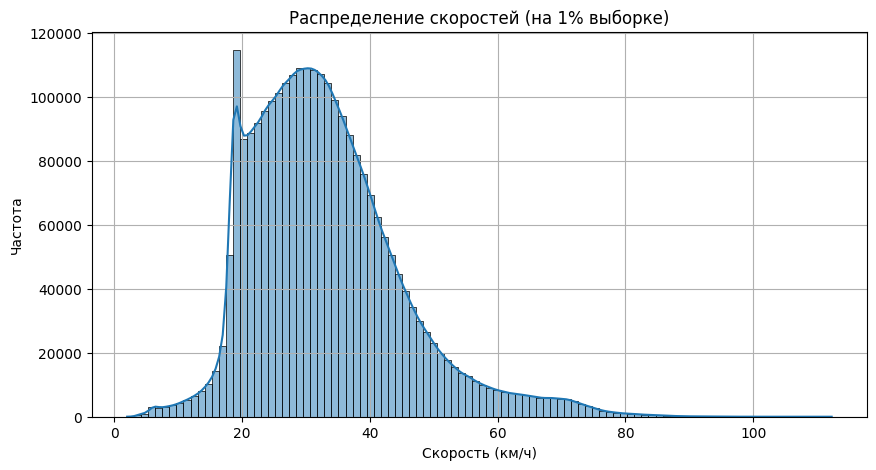

In [ ]:
sample_df = df_clean.sample(frac=0.01, random_state=42)

plt.figure(figsize=(10, 5))
sns.histplot(sample_df['traffic_speed'], bins=100, kde=True)
plt.title("Распределение скоростей (на 1% выборке)")
plt.xlabel("Скорость (км/ч)")
plt.ylabel("Частота")
plt.grid()
plt.show()

# Добавляем столбец datetime

учитывая, что столбец timestamp представляет собой номера 15-минутных интервалов, начиная с 1 апреля 2017 года.

In [ ]:
# Период: с 1 апреля по 31 мая 2017
start_time = datetime.datetime(2017, 4, 1, 0, 0)
df_clean['datetime'] = df_clean['timestamp'].apply(lambda x: start_time + datetime.timedelta(minutes=15 * x))
df_clean['hour'] = df_clean['datetime'].dt.hour
df_clean['day_of_week'] = df_clean['datetime'].dt.dayofweek  # 0 - понедельник, 6 - воскресенье

In [ ]:
df_clean.head()

,road_segment_id,timestamp,traffic_speed,datetime,hour,day_of_week
0,1562548955,0,41.348069,2017-04-01 00:00:00,0,5
1,1562548955,1,37.241356,2017-04-01 00:15:00,0,5
2,1562548955,2,33.832750,2017-04-01 00:30:00,0,5
3,1562548955,3,40.403444,2017-04-01 00:45:00,0,5
4,1562548955,4,49.843057,2017-04-01 01:00:00,1,5


# Анализ зависимости скорости от времени суток (на случайной подвыборке)

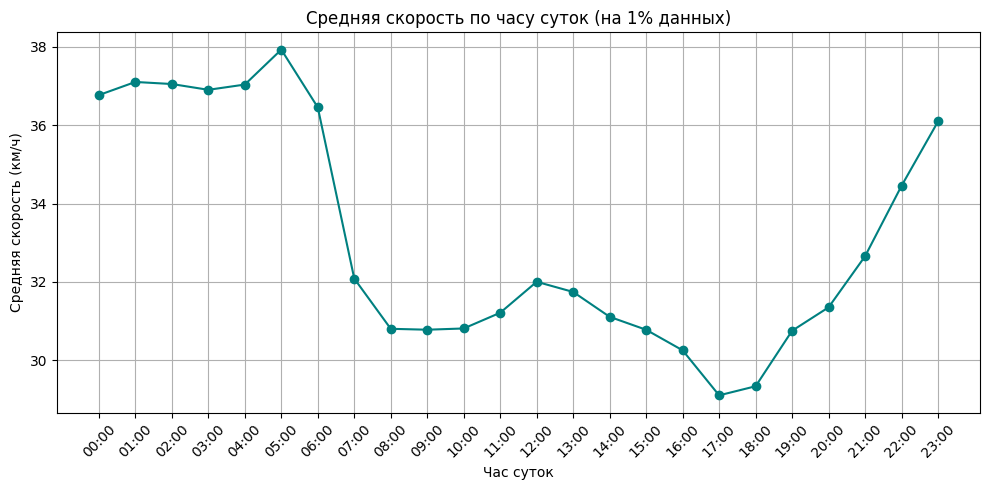

In [ ]:
sample_fraction = 0.01

df_sample = df_clean.sample(frac=sample_fraction, random_state=42)

hourly_speed = df_sample.groupby('hour')['traffic_speed'].mean()

hour_labels = [f"{h:02d}:00" for h in hourly_speed.index]

plt.figure(figsize=(10, 5))
plt.plot(hour_labels, hourly_speed.values, marker='o', color='teal')
plt.title(f"Средняя скорость по часу суток (на {int(sample_fraction * 100)}% данных)")
plt.xlabel("Час суток")
plt.ylabel("Средняя скорость (км/ч)")
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

# Средняя скорость по времени суток

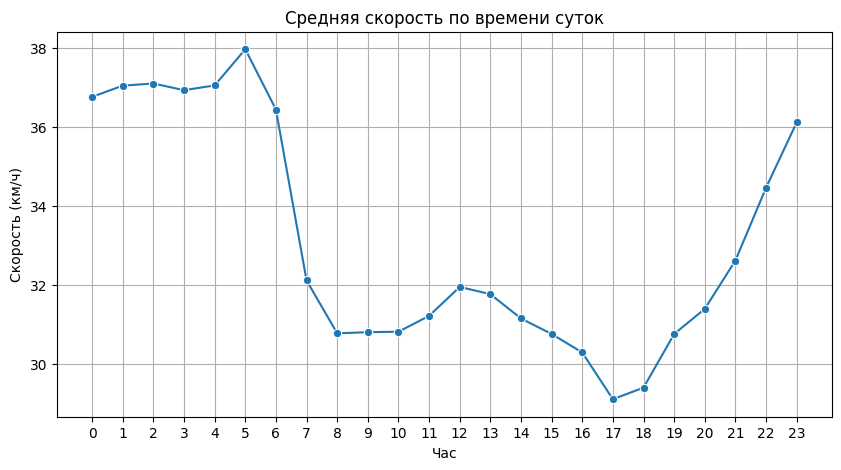

In [ ]:
mean_speed_per_hour = df_clean.groupby('hour')['traffic_speed'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.lineplot(x='hour', y='traffic_speed', data=mean_speed_per_hour, marker='o')
plt.title("Средняя скорость по времени суток")
plt.xlabel("Час")
plt.ylabel("Скорость (км/ч)")
plt.grid()
plt.xticks(range(0, 24))
plt.show()

# Анализ по дням недели

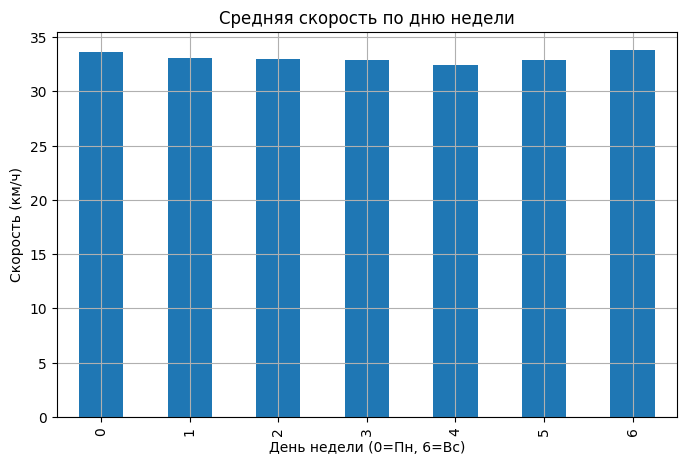

In [ ]:
dow_speed = df_clean.groupby('day_of_week')['traffic_speed'].mean()
plt.figure(figsize=(8, 5))
dow_speed.plot(kind='bar')
plt.title("Средняя скорость по дню недели")
plt.xlabel("День недели (0=Пн, 6=Вс)")
plt.ylabel("Скорость (км/ч)")
plt.grid()
plt.show()

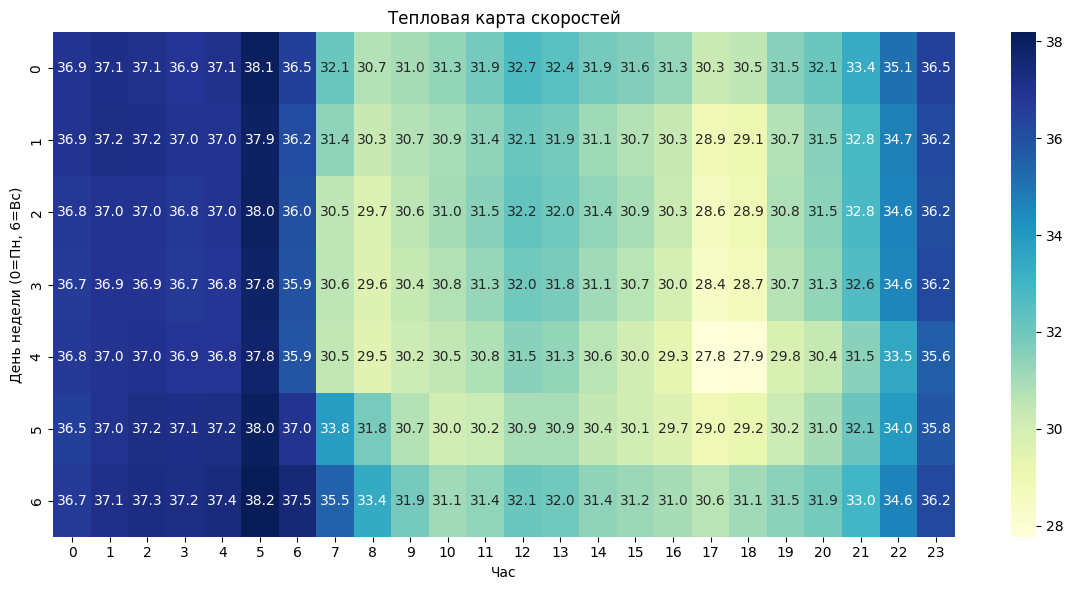

In [ ]:
pivot = df_clean.pivot_table(index='day_of_week', columns='hour', values='traffic_speed', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title(f"Тепловая карта скоростей")
plt.xlabel("Час")
plt.ylabel("День недели (0=Пн, 6=Вс)")
plt.tight_layout()
plt.show()

# Анализ по конкретному участку дороги (первый из датасета)

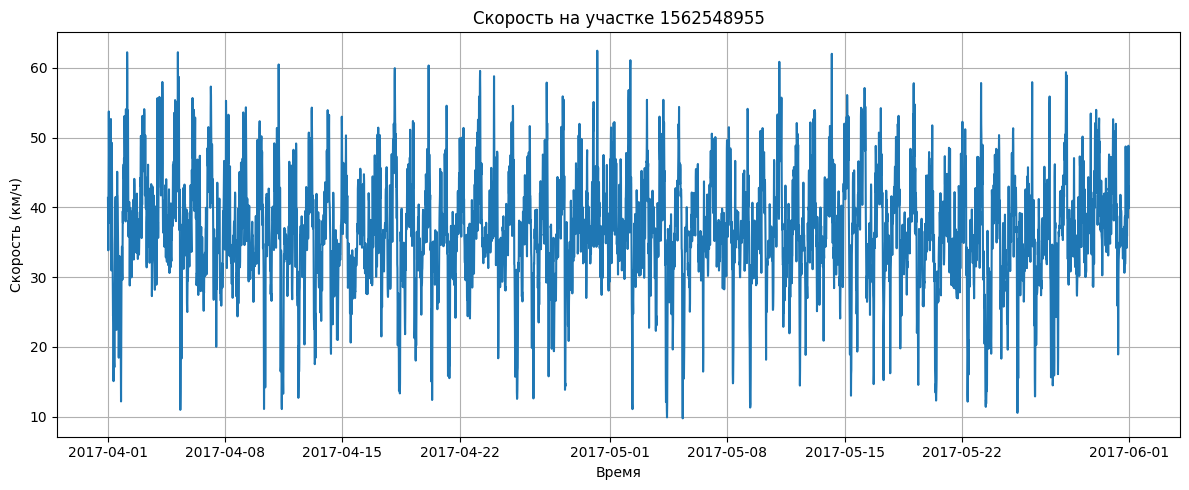

In [ ]:
sample_link = df_clean.iloc[0]['road_segment_id']
df_link = df_clean[df_clean['road_segment_id'] == sample_link]
plt.figure(figsize=(12, 5))
plt.plot(df_link['datetime'], df_link['traffic_speed'])
plt.title(f"Скорость на участке {sample_link}")
plt.xlabel("Время")
plt.ylabel("Скорость (км/ч)")
plt.grid()
plt.tight_layout()
plt.show()

На графике видны регулярные пики и провалы. Из этого можно предположить наличие пиковых часов (утро/вечер) и низкой активности в ночные часы.

Данные достаточно "зубчатые", что может свидетельствовать о высоком трафике с регулярными колебаниями.

Построим график средней скорости по дням:

<ipython-input-18-ddc9d43aecf4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_link['date'] = df_link['datetime'].dt.date


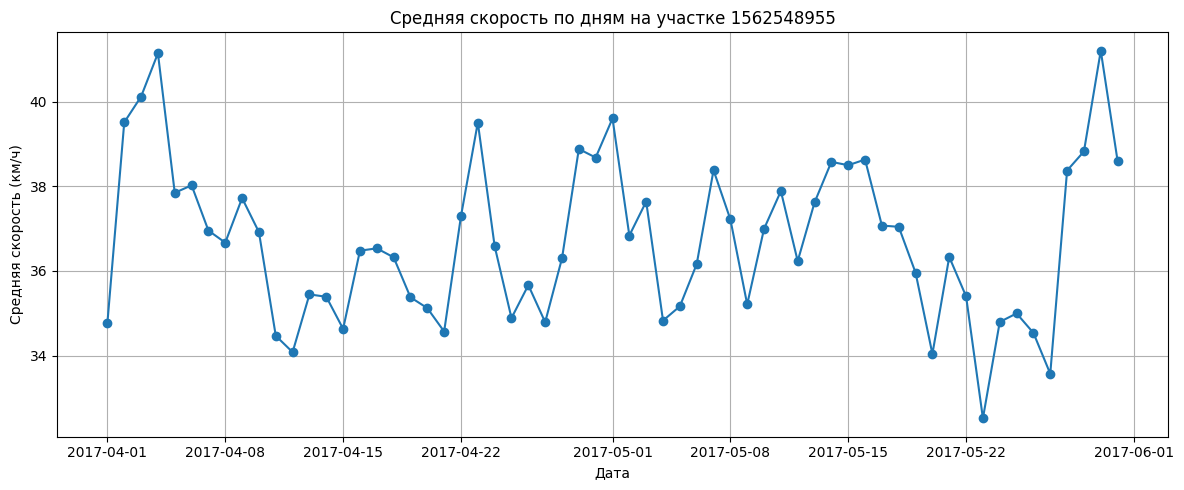

In [ ]:
df_link['date'] = df_link['datetime'].dt.date
daily_speed = df_link.groupby('date')['traffic_speed'].mean()

plt.figure(figsize=(12, 5))
daily_speed.plot(marker='o')
plt.title(f"Средняя скорость по дням на участке {sample_link}")
plt.xlabel("Дата")
plt.ylabel("Средняя скорость (км/ч)")
plt.grid()
plt.tight_layout()
plt.show()

Есть недельный цикл - каждые 5–7 дней скорость падает, затем снова поднимается. Это согласуется с предположением, что:
*   выходные дни => выше средняя скорость,
*   будние дни => ниже из-за пробок.


В районе 1–3 апреля и в самом конце мая видны аномально высокие значения. Возможные причины: праздники, каникулы, ограниченное движение.

Можно заметить волнообразное движение без ярко выраженного общего тренда вверх или вниз. Это подтверждает цикличность трафика, зависящую от дня недели и времени месяца.

Разобьем данные по часам, чтобы увидеть типичное суточное поведение:

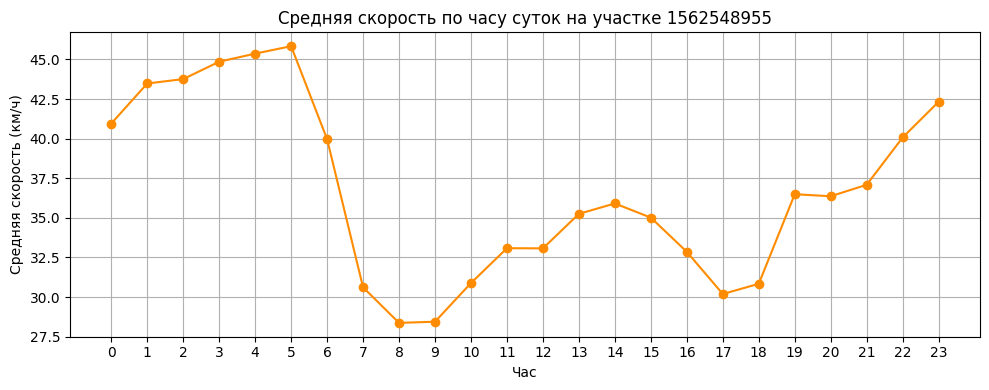

In [ ]:
hourly_speed = df_link.groupby('hour')['traffic_speed'].mean()

plt.figure(figsize=(10, 4))
hourly_speed.plot(marker='o', color='darkorange')
plt.title(f"Средняя скорость по часу суток на участке {sample_link}")
plt.xlabel("Час")
plt.ylabel("Средняя скорость (км/ч)")
plt.xticks(range(0, 24))
plt.grid()
plt.tight_layout()
plt.show()

* График хорошо отражает типичную суточную динамику городского трафика.

* Два выраженных "часа пик" (утро и вечер).


Тепловая карта "день недели vs час".
Позволит обнаружить паттерны в зависимости от дня и времени:

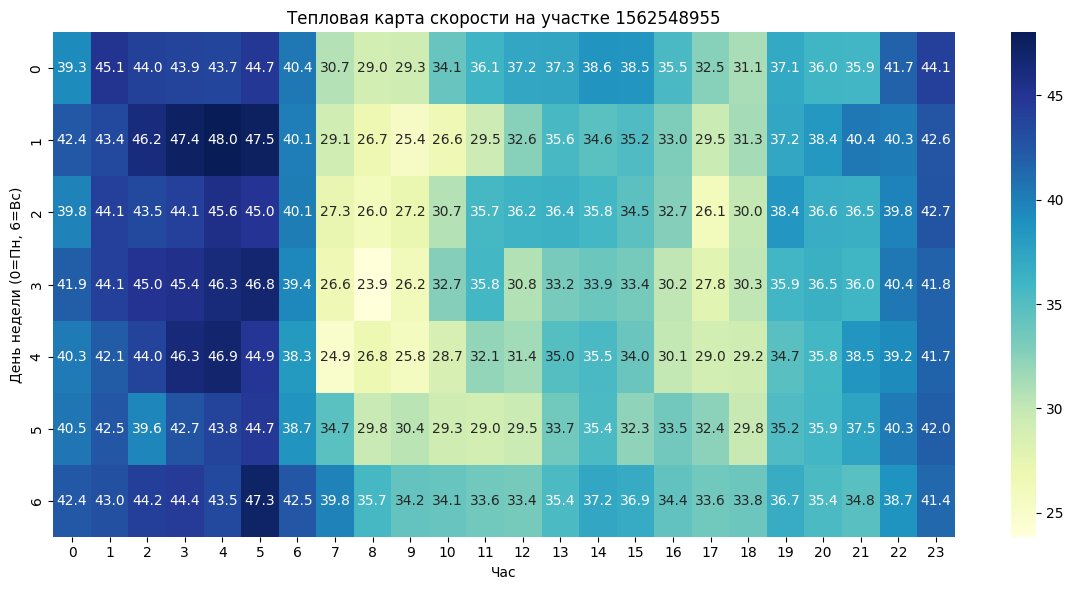

In [ ]:
pivot = df_link.pivot_table(index='day_of_week', columns='hour', values='traffic_speed', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(pivot, cmap='YlGnBu', annot=True, fmt=".1f")
plt.title(f"Тепловая карта скорости на участке {sample_link}")
plt.xlabel("Час")
plt.ylabel("День недели (0=Пн, 6=Вс)")
plt.tight_layout()
plt.show()

# Добавим признак "является ли выходным днем"

In [ ]:
df_clean['is_weekend'] = df_clean['day_of_week'].isin([5, 6]).astype(int)

In [ ]:
df_clean.head()

,road_segment_id,timestamp,traffic_speed,datetime,hour,day_of_week,is_weekend
0,1562548955,0,41.348069,2017-04-01 00:00:00,0,5,1
1,1562548955,1,37.241356,2017-04-01 00:15:00,0,5,1
2,1562548955,2,33.832750,2017-04-01 00:30:00,0,5,1
3,1562548955,3,40.403444,2017-04-01 00:45:00,0,5,1
4,1562548955,4,49.843057,2017-04-01 01:00:00,1,5,1


# Сравнение средней скорости по часу для будней и выходных


сузим анализ до одной недели и нескольких случайных участков дороги. Это поможет сократить объем данных и ускорить визуализацию, не теряя при этом возможности увидеть закономерности.

Выберем случайные road_segment_id.

Возьмем данные одной недели.

Построим сравнение скоростей по часу — будни vs выходные.

In [ ]:
NUM_SEGMENTS = 3         # кол-во случайных сегментов
START_DATE = pd.to_datetime("2017-04-03")  # понедельник
END_DATE = START_DATE + pd.Timedelta(days=7)

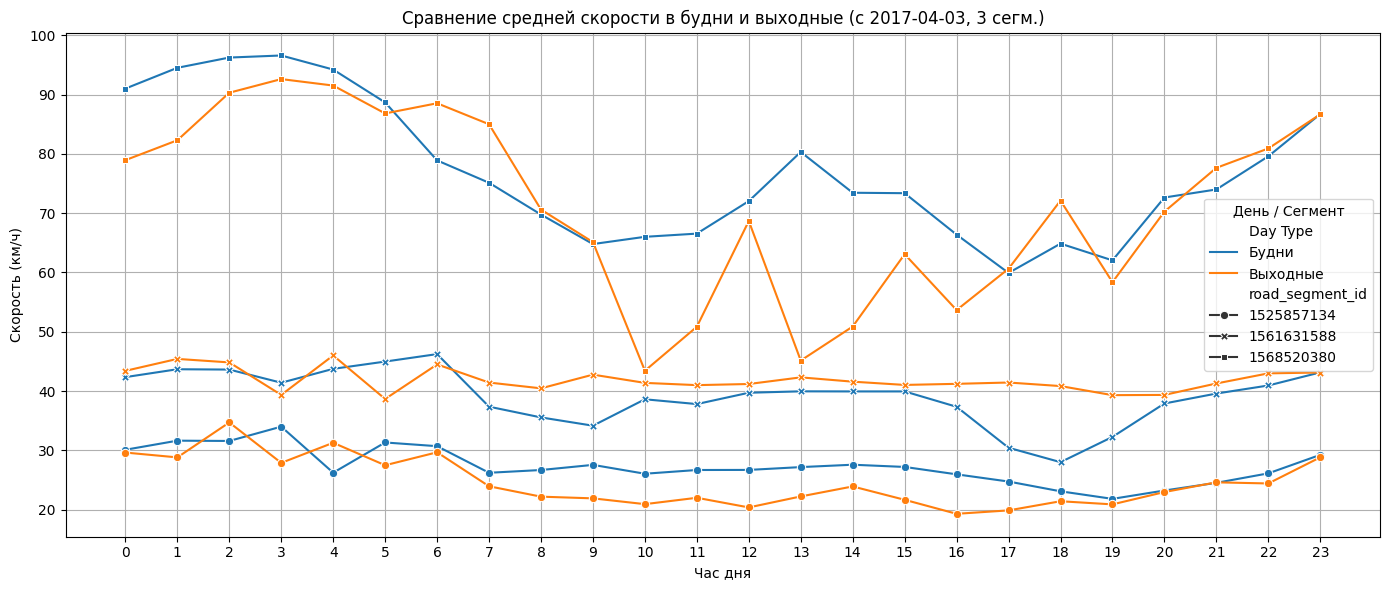

In [ ]:
unique_segments = df_clean['road_segment_id'].unique()
random_segments = np.random.choice(unique_segments, NUM_SEGMENTS, replace=False)

df_sample = df_clean[
    (df_clean['road_segment_id'].isin(random_segments)) &
    (df_clean['datetime'] >= START_DATE) &
    (df_clean['datetime'] < END_DATE)
].copy()

df_sample['hour'] = df_sample['datetime'].dt.hour
df_sample['day_of_week'] = df_sample['datetime'].dt.dayofweek
df_sample['is_weekend'] = df_sample['day_of_week'].isin([5, 6]).astype(int)

avg_by_hour_weekend_segment = (
    df_sample.groupby(['hour', 'is_weekend', 'road_segment_id'])['traffic_speed']
    .mean()
    .reset_index()
)

avg_by_hour_weekend_segment['Day Type'] = avg_by_hour_weekend_segment['is_weekend'].map({0: 'Будни', 1: 'Выходные'})

plt.figure(figsize=(14, 6))
sns.lineplot(
    data=avg_by_hour_weekend_segment,
    x='hour', y='traffic_speed',
    hue='Day Type',
    style='road_segment_id',
    markers=True,
    dashes=False
)
plt.title(f"Сравнение средней скорости в будни и выходные (с {START_DATE.date()}, {NUM_SEGMENTS} сегм.)")
plt.xlabel("Час дня")
plt.ylabel("Скорость (км/ч)")
plt.grid()
plt.legend(title='День / Сегмент')
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# НАПИСАТЬ ВЫВОД (блок выше)

# Перевод в циклический вид признаков дней недели

In [ ]:
df_clean['dow_rad'] = 2 * np.pi * df_clean['datetime'].dt.dayofweek / 7
df_clean['dow_sin'] = np.sin(df_clean['dow_rad'])
df_clean['dow_cos'] = np.cos(df_clean['dow_rad'])
df_clean.drop(columns=['dow_rad'], inplace=True)

In [ ]:
df_clean.head()

,road_segment_id,timestamp,traffic_speed,datetime,hour,day_of_week,is_weekend,dow_sin,dow_cos,hour_rad,hour_sin,hour_cos
0,1562548955,0,41.348069,2017-04-01 00:00:00,0,5,1,-0.974928,-0.222521,0.000000,0.000000,1.000000
1,1562548955,1,37.241356,2017-04-01 00:15:00,0,5,1,-0.974928,-0.222521,0.000000,0.000000,1.000000
2,1562548955,2,33.832750,2017-04-01 00:30:00,0,5,1,-0.974928,-0.222521,0.000000,0.000000,1.000000
3,1562548955,3,40.403444,2017-04-01 00:45:00,0,5,1,-0.974928,-0.222521,0.000000,0.000000,1.000000
4,1562548955,4,49.843057,2017-04-01 01:00:00,1,5,1,-0.974928,-0.222521,0.261799,0.258819,0.965926


# Переведом признак hour в цикличнский формат

In [ ]:
df_clean['hour_rad'] = 2 * np.pi * df_clean['hour'] / 24 # to radian

df_clean['hour_sin'] = np.sin(df_clean['hour_rad']) # add sin and cos
df_clean['hour_cos'] = np.cos(df_clean['hour_rad'])

KeyError: 'hour'

In [ ]:
df_clean.head()

,road_segment_id,timestamp,traffic_speed,datetime,hour,day_of_week,is_weekend,dow_sin,dow_cos,hour_rad,hour_sin,hour_cos
0,1562548955,0,41.348069,2017-04-01 00:00:00,0,5,1,-0.974928,-0.222521,0.000000,0.000000,1.000000
1,1562548955,1,37.241356,2017-04-01 00:15:00,0,5,1,-0.974928,-0.222521,0.000000,0.000000,1.000000
2,1562548955,2,33.832750,2017-04-01 00:30:00,0,5,1,-0.974928,-0.222521,0.000000,0.000000,1.000000
3,1562548955,3,40.403444,2017-04-01 00:45:00,0,5,1,-0.974928,-0.222521,0.000000,0.000000,1.000000
4,1562548955,4,49.843057,2017-04-01 01:00:00,1,5,1,-0.974928,-0.222521,0.261799,0.258819,0.965926


# Удалим лишние столбцы
datetime	Полная дата и время	- Использовалась для извлечения признаков, но сама по себе не используется напрямую в ML.


is_weekend	Бинарный флаг: выходной или нет	-	Уже закодировано в dow_5 и dow_6 (это суббота и воскресенье), дублируется.

In [ ]:
df_clean = df_clean.drop(columns=['datetime', 'hour', 'hour_rad'])

In [ ]:
df_clean = df_clean.drop(columns=['day_of_week'])

In [ ]:
df_clean.head()

,road_segment_id,timestamp,traffic_speed,is_weekend,dow_sin,dow_cos,hour_sin,hour_cos
0,1562548955,0,41.348069,1,-0.974928,-0.222521,0.000000,1.000000
1,1562548955,1,37.241356,1,-0.974928,-0.222521,0.000000,1.000000
2,1562548955,2,33.832750,1,-0.974928,-0.222521,0.000000,1.000000
3,1562548955,3,40.403444,1,-0.974928,-0.222521,0.000000,1.000000
4,1562548955,4,49.843057,1,-0.974928,-0.222521,0.258819,0.965926


В результате в df_clean у нас останутся:

timestamp (для упорядочивания/окон),

traffic_speed,

hour_sin, hour_cos,

dow_sin, dow_cos,

(возможно) is_weekend -  дублирует часть информации dow_cos|dow_sin.

Как это влияет на обучение

* Cyclical encoding позволяет GNN (или любому ML-модулю) учесть, что 23:00 близко к 0:00 и воскресенье к понедельнику.

* Убирая one-hot, мы снижаем размер входа и риск переобучения на “штучных” различиях между номерами дней.

* Плюс-против: для простоты и интерпретируемости можно оставить is_weekend (1/0), но для дня недели достаточно двух цикличных признаков.

# Сохраним преобразованные данные в формат .parquet

In [ ]:
df_clean.to_parquet("processed_traffic_speed.parquet", index=False)